# SB 827 Analysis
## September 2018 re-work

<h2> to do: </h2>
<ol>
    <li> fix interpolator </li>
    <li> add functionality to deal with different service_ids </li>
</ol>

### prologue

In [49]:
import pandas as pd, numpy as np, time, datetime, csv, os
from matplotlib import pyplot as plt

In [2]:
# specify agency
path = 'gtfs/ac-transit--121/'

In [3]:
print(path)
print("-------")

agency_name = pd.read_csv(path + 'agency.txt')['agency_name'][0]
print(agency_name)

trips = pd.read_csv(path + 'trips.txt')
print(len(trips), "trips")

routes = pd.read_csv(path + 'routes.txt')
print(len(routes), "routes")

stops = pd.read_csv(path + 'stops.txt')
print(len(stops), "stops")

stop_times = pd.read_csv(path + 'stop_times.txt')
print(len(stop_times), "stop times")

calendar = pd.read_csv(path + "calendar.txt")
print(len(calendar), "schedules")

gtfs/ac-transit--121/
-------
AC Transit
15388 trips
152 routes
5332 stops
677042 stop times
89 schedules


In [4]:
trips2directions = dict(zip(trips['trip_id'], trips['direction_id']))
trips2service = dict(zip(trips['trip_id'], trips['service_id']))
trips2routes = dict(zip(trips['trip_id'], trips['route_id']))
routes2headsigns = dict(zip(routes['route_id'], routes['route_short_name']))

In [5]:
def minSinceMidnight(t):
    if type(t) == str:
        tt = t.split(':')
        msm = (int(tt[0])*60) + int(tt[1]) + (int(tt[2])/60)
    else:
        msm = t
    return msm

In [6]:
## BROKEN
## NEEDS REWRITING AFTER DOWNLOADING CURRENT AC TRANSIT GTFS

def interpolator(trip):
    
    lsst = list(stop_times[stop_times['trip_id'] == trip]['arrival_time'])
    
    lsst = [minSinceMidnight(x) for x in lsst]
    
    
    last_scheduled_time = lsst[0]
    lst_index = 0
    
    values = [last_scheduled_time]
    
    for x in lsst[1:]:
        if pd.isnull(x) == False:
            idx = lsst.index(x)
            yy = list(np.linspace(last_scheduled_time, x, num=(idx-lst_index+1)))

            values += yy[1:]
            last_scheduled_time = x
            lst_index = idx
        else:
            pass
    return values # returns linear interpolation of times

<h2> interpolation </h2>

In [7]:
agency_trips = list(trips['trip_id'].unique())

if (sum(pd.isnull(stop_times['arrival_time']))/len(stop_times)) > 0.15:
    allInterpolatedTimes = []

    intrS = time.time()
    for trip in agency_trips:
        allInterpolatedTimes += interpolator(trip)
    intrF = time.time()

    print("interpolated " + str(len(agency_trips)), "trips ("+ str(len(stop_times))+" stops) in", str(intrF - intrS), "seconds")
else:
    allInterpolatedTimes = [minSinceMidnight(x) for x in stop_times['arrival_time']]
    print("did not interpolate")

did not interpolate


In [8]:
stop_times['interpolated'] = allInterpolatedTimes
stop_times['direction_id'] = [trips2directions[x] for x in stop_times['trip_id']]
stop_times['service_id'] = [trips2service[x] for x in stop_times['trip_id']]

In [73]:
# nothing important

unique_stops = stop_times['stop_id'].unique()

for stop in unique_stops[:1]:
    for direction in [0,1]:
        tempDF = stop_times[(stop_times['stop_id'] == stop) & (stop_times['direction_id'] == direction)]

In [9]:
# DETERMINE THE MOST COMMON SCHEDULES


pct_service = dict(trips['service_id'].value_counts()/len(trips))


weekday_query = "monday == 1 & tuesday == 1 & wednesday == 1 & thursday == 1 & friday == 1 & saturday == 0 & sunday == 0"
saturday_query = "monday == 0 & tuesday == 0 & wednesday == 0 & thursday == 0 & friday == 0 & saturday == 1 & sunday == 0"
sunday_query = "monday == 0 & tuesday == 0 & wednesday == 0 & thursday == 0 & friday == 0 & saturday == 0 & sunday == 1"

weekday_service = list(calendar.query(weekday_query)['service_id'])
saturday_service = list(calendar.query(saturday_query)['service_id'])
sunday_service = list(calendar.query(sunday_query)['service_id'])

del weekday_query, saturday_query, sunday_query # don't need these anymore



# schedules are stored in an array with an eventual length = 3
schedules = []

# index 0 = weekday
# index 1 = saturday
# index 2 = sunday

for services in [weekday_service, saturday_service, sunday_service]:
    boop = {k:v for (k,v) in pct_service.items() if k in services}
    schedules.append(max(boop, key=boop.get))

schedules # identifies the most common of each service type

['1808FA-D2-Weekday-03', '1808FA-D2-Saturday-01', '1808FA-D2-Sunday-01']

In [10]:
# queries to filter by various time criteria
# strings for pd.DF.query

am_peak_query = "interpolated >= 360 and interpolated <= 600"
pm_peak_query = "interpolated >= 900 and interpolated <= 1140"
weekday_range_query = "interpolated >= 360 and interpolated <= 1320"
saturday_range_query = "interpolated >= 480 and interpolated <= 1320"
sunday_range_query = "interpolated >= 480 and interpolated <= 1320"

In [11]:
# defines the schema for the dict object holding headways

dataHolderSpec = {
                  "name":'',
                  "longitude":np.NaN,
                  "latitude":np.NaN,
                0: {
                    "served_by": [],
                    "AM Peak": np.NaN,
                    "PM Peak": np.NaN,
                    "Weekdays": np.NaN,
                    "Saturday": np.NaN,
                    "Sunday": np.NaN
                     },
                 1: {
                    "served_by": [],
                    "AM Peak": np.NaN,
                    "PM Peak": np.NaN,
                    "Weekdays": np.NaN,
                    "Saturday": np.NaN,
                    "Sunday": np.NaN
                     }
                 }

In [12]:
# create dictionary object to hold information about stops
# dictionary will be used for quick access

stops_data = {}

for i in range(len(stops)):
    stop_id = stops['stop_id'][i]
    stop_name = stops['stop_name'][i]
    stop_lon = stops['stop_lon'][i]
    stop_lat = stops['stop_lat'][i]
    
    stops_data[stop_id] = {
        "name": stop_name,
        "lon": stop_lon,
        "lat": stop_lat
    }

### required fields for output:
<ol>
    <li>agency</li> 
    <li>stop id</li>
    <li>stop name</li>
    <li>stop x</li>
    <li>stop y</li>
    <li>am peak headway (IB)</li>
    <li>pm peak headway (IB)</li>
    <li>weekday headway (IB)</li>
    <li>saturday headway (IB)</li>
    <li>sunday headway (IB)</li>
    <li>am peak headway (OB)</li>
    <li>pm peak headway (OB)</li>
    <li>weekday headway (OB)</li>
    <li>saturday headway (OB)</li>
    <li>sunday headway (OB)</li>
</ol>

<p><i> The CSV output for each agency should have the above attributes as unique fields. </i></p>

In [62]:
# make sure directory for saving outputs exists
if os.path.isdir("output") == False:
    os.mkdir("output")
else:
    pass

timeS = time.time() # start time, for evaluation

# path for output CSV
filename = "output/%s_test.csv" % agency_name

# CSV writer
f = open(filename, 'w')
writer = csv.writer(f)
writer.writerow(["Stop ID", "Name", "Agency", "X", "Y", "OB Routes", "OB AM Peak", "OB PM Peak", "OB Weekday", "OB Saturday", "OB Sunday", "IB Routes", "IB AM Peak", "IB PM Peak", "IB Weekday", "IB Saturday", "IB Sunday"])

# ordered list of different time windows to evaluate
filter_options = ['AM Peak', "PM Peak", 'Weekdays', 'Saturday', 'Sunday']


# the following lists are in the same order as filter_options, so indices would be common across lists
# e.g. filter_options[0] is "AM Peak" and filters[0] is am_peak_query, and filter_sched[0] is the weekday schedule, etc.
# this feels kind of messy and we may want to play with cleaning this up
filters = [am_peak_query, pm_peak_query, weekday_range_query, saturday_range_query, sunday_range_query]
filter_sched = [0,0,0,1,2] # index of service_id in schedules array
filter_time_per = [4,4,16,14,14] # number of hours in each evaluative window
filter_crit = [16,16,48,28,28] # number of required buses during evaluative window


# list of unique stops in that transit system
unique_stops = stop_times['stop_id'].unique()

# number of stops to evaluate
# to run for the entire agency, set num_of_stops = len(unique_stops)
num_of_stops = 1000

for stop in unique_stops[:num_of_stops]:
    # stop characteristics
    
    # add a "0" to stop_ids because AC Transit stores stop_ids as seven-character strings
    # this will need to be made flexible when this is reworked to accomodate other agencies
    if len(str(stop)) < 7:
        stringstop = "0" + str(stop)
    else:
        stringstop = str(stop)
        
    sub_stops_data = stops_data[stringstop] # subset of larger dictionary to make data storage syntax cleaner
    
    # use defined dictionary variable from previous cell and populate with name and location info from stops DF
    dataHolder = dataHolderSpec 
    dataHolder['name'] = sub_stops_data['name']
    dataHolder['longitude'] = sub_stops_data['lon']
    dataHolder['latitude'] = sub_stops_data['lat']
    
    for direction in [0,1]: # iterate through both directions
        # create a DF that contains one stop in one direction
        # ex. stop_id 300315, direction_id  0
        tempDF = stop_times[(stop_times['stop_id'] == stop) & (stop_times['direction_id'] == direction)]
        
        # generate a list of all the short names for the routes that stop at the defined stop in the defined direction 
        served_by = list(set([routes2headsigns[trips2routes[x]] for x in  tempDF['trip_id']]))
        
        if len(served_by) == 0:
            served_by == np.NaN
        else:
            pass
        
        #print()
        #print(stop, sub_stops_data['name'], served_by, "-", direction)
        
        
        for option in filter_options:
            
            i = filter_options.index(option) # list index for that time window
            fltr = filters[i]
            fltr_sched = schedules[filter_sched[i]]
            
            # integer for the number of buses that stop at a given stop in a given direction 
            # during the time period defined by the query expression
            num_buses = len(tempDF[tempDF['service_id'] == fltr_sched].query(fltr))
            
            # right now, headway calculation doesn't work when service doesn't run for the entirety of the evaluative window
            # ex. AC TRANSIT stop 300315, line 65 ends at 6:30pm on weekends (does not run until 10pm)
           
        
            # crudely calculate average headway by dividing the total number of minutes during the defined time period
            # by the number of buses that stopped during that time period (num_buses)
            try:
                headway = round(((filter_time_per[i] * 60) / num_buses), 2)
            except ZeroDivisionError:
                headway = np.NAN
            
            dataHolder[direction]['served_by'] = served_by
            dataHolder[direction][filter_options[i]] = headway
            
            #print(filter_options[i] + ": " + str(num_buses) + " of " + str(filter_crit[i]) + " required. (" + str(headway) + " min headway)")
    
    ob = dataHolder[0] # subset of larger dictionary (just outbound) to make data storage syntax cleaner
    ib = dataHolder[1] # subset of larger dictionary (just inbound) to make data storage syntax cleaner
    
    # write data to CSV
    row_contents = [stop, dataHolder['name'], agency_name, dataHolder['longitude'], dataHolder['latitude'], ', '.join(ob['served_by']), ob['AM Peak'], ob['PM Peak'], ob['Weekdays'], ob['Saturday'], ob['Sunday'], ', '.join(ib['served_by']), ib['AM Peak'], ib['PM Peak'], ib['Weekdays'], ib['Saturday'], ib['Sunday']]
    writer.writerow(row_contents)
timeF = time.time() # finish time, for evaluation
f.close()

print()  
# print duration of process, number of stops, and rate
print(str(round((timeF - timeS),2)), "seconds //", str(num_of_stops), "stops //", str(round((round((timeF - timeS),2)/num_of_stops),4)), "seconds per stop")


55.28 seconds // 1000 stops // 0.0553 seconds per stop


In [63]:
# way to evaluate output for GHOST STOPS (nan all the way through)
# ghosts stops are likely served by trips with different service_IDs so we aren't seeing them


output_path = 'output/%s_test.csv' % agency_name
ghost_path = 'output/%s_ghosts.csv' % agency_name

output = pd.read_csv(output_path) # read in output data as a new Pandas DF

output.head()

ghost_stops = output[(np.isnan(output['OB Weekday']) == True) & (np.isnan(output['OB Saturday']) == True) & (np.isnan(output['OB Sunday']) == True) &  (np.isnan(output['IB Weekday']) == True) & (np.isnan(output['IB Saturday']) == True) & (np.isnan(output['IB Sunday']) == True)][['Stop ID', 'Name', 'X', 'Y']].reset_index()

ghost_stops.to_csv(ghost_path)

pct_ghost = round((len(ghost_stops)/len(output)), 3) * 100

print(str(pct_ghost) + "% ghost stops")


10.0% ghost stops


### misc

In [58]:
'''
GUTS OF INTERPOLATOR



trip_id = stop_times['trip_id'][400]
tempDF = stop_times[stop_times['trip_id'] == trip_id]

arrivalTimes = [minSinceMidnight(x) for x in list(tempDF['arrival_time'])]

last_scheduled_time = arrivalTimes[0]
lst_index = 0

values = [last_scheduled_time]

for x in arrivalTimes[1:]:
    if pd.isnull(x) == False:
        idx = arrivalTimes.index(x)
        yy = list(np.linspace(last_scheduled_time, x, num=(idx-lst_index+1)))
        
        values += yy[1:]
        last_scheduled_time = x
        lst_index = idx
    else:
        pass
'''

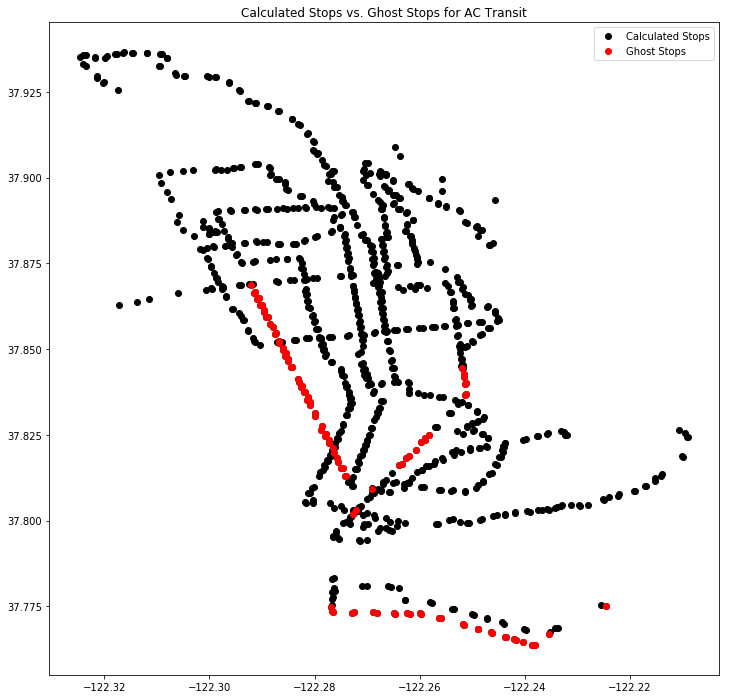

In [85]:
# visualize ghost stops

plot_title = "Calculated Stops vs. Ghost Stops for %s" % agency_name 

plt.clf()
plt.figure(figsize=(12,12))

plt.plot(output['X'], output['Y'], 'ok')
plt.plot(ghost_stops['X'], ghost_stops['Y'], 'or')


plt.legend(["Calculated Stops", "Ghost Stops"])
plt.title(plot_title)
plt.show()